### cutoff frequency 가 linear하게 올라가는 lowpass filter
- 10ms shift
- 3ms overlap
    - trapezoidal

- refference: `https://github.com/11jeonghy/SSP2023_assignments/blob/main/lab03/linear_filter.ipynb`

In [1]:
# import necessary pacakages
# strange issue: keep the import order to prevent matplotlib error
#  import matplotlib -> librosa -> pyplot -> librosa.display
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift

### 1. Make the code

In [ ]:
def getFIRFFT(H, order, winname=None):
    # H: NFFT/2+1
    NFFT = (len(H)-1)*2
    H = np.concatenate((H, H[-2:0:-1])) + np.zeros(NFFT)*(1j)
    h = np.fft.ifft(H, NFFT)
    order = min(NFFT-1, order)
    #h = np.concatenate((h[len(h)//2:], h[0:len(h)//2]))
    h = np.concatenate((h[(len(h)-order//2):], h[0:order//2+1]))
    if winname != None:
        win = librosa.filters.get_window(winname, order+1, fftbins=False)
        h = h*win
    return h.real

### 2. Make the code

In [2]:
# parameters for drawing
#cmap_plot = plt.cm.bone # default colormap for spectrogram, gray
cmap_plot = plt.cm.bone_r # default colormap for spectrogram, gray, reversed
#cmap_plot = plt.cm.plasma 
#cmap_plot = plt.cm.inferno
#FIG_SIZE = (15,10)   # obsolete
FIG_SIZE = (8,3)

In [3]:
def getFIRFFT(H, order, winname=None):
    # H: NFFT/2+1
    NFFT = (len(H)-1)*2
    H = np.concatenate((H, H[-2:0:-1])) + np.zeros(NFFT)*(1j)
    h = np.fft.ifft(H, NFFT)
    order = min(NFFT-1, order)
    #h = np.concatenate((h[len(h)//2:], h[0:len(h)//2]))
    h = np.concatenate((h[(len(h)-order//2):], h[0:order//2+1]))
    if winname != None:
        win = librosa.filters.get_window(winname, order+1, fftbins=False)
        h = h*win
    return h.real

def drawFIRFFT(h, NFFT=512):
    plt.subplot(1,2,1)
    plt.plot(h)
    plt.xlabel('time (in samples)')
    plt.ylabel('amplitude')
    plt.subplot(1,2,2)
    NFFT = max(len(h), NFFT)
    xticks=np.linspace(0, 2, num=NFFT, endpoint=True)
    #plt.plot(xticks, np.fft.fft(a, NFFT).real)
    #plt.plot(xticks, np.fft.fft(a, NFFT).imag)
    plt.plot(xticks, np.abs(np.fft.fft(h, NFFT)))
    plt.xlabel('frequency (*pi radians)')
    plt.ylabel('magnitude')
    return h

getFIRFFT(np.arange(33), 10, 'hamming')

array([-0.02117231,  0.        , -0.28873613,  0.        , -5.91962644,
       16.        , -5.91962644,  0.        , -0.28873613,  0.        ,
       -0.02117231])

In [24]:
def trapezoidal_win(cutoff_freq=100, fs=16000, side_size=0.3, center_size=0.4):
    
    if side_size*2 + center_size !=1:
        print("trapezoidal window size error")
        return 0
    
    samples_per_freq = int(fs/cutoff_freq)
    
    left_samples = int(samples_per_freq*side_size)
    mid_samples = int(samples_per_freq*center_size)
    right_samples = int(samples_per_freq*side_size)
    
    left_range = np.arange(0, np.pi/2, np.pi/(2*left_samples))
    right_range = np.arange(0, np.pi/2, np.pi/(2*right_samples))
    print(left_range.shape, right_range.shape)
    
    left_values = np.sin(left_range)
    mid_values = np.ones(mid_samples)
    right_values = np.square(np.cos(right_range))
    
    return np.concatenate((left_values, mid_values, right_values))
    

In [5]:
def get_linear_FIR(cutoff_freq=100, wav_file='./gjang-kdigits0-3.wav', order=14, winname='hamming'):
    FIR_list = []
    
    x, fs = librosa.load(wav_file, sr=None, mono=True)
    total_time = len(x)/fs
    total_div = int(total_time*cutoff_freq)
    
    for i in range(total_div):
        H = [1.0]*int(i*order/total_div) + [0.0]*(order-int(i*order/total_div))
        h = getFIRFFT(np.array(H), order, winname)
        FIR_list.append(h)
    return FIR_list

In [11]:
x2 = get_linear_FIR(cutoff_freq=100, wav_file='./gjang-kdigits0-3.wav', order=14, winname='hamming')

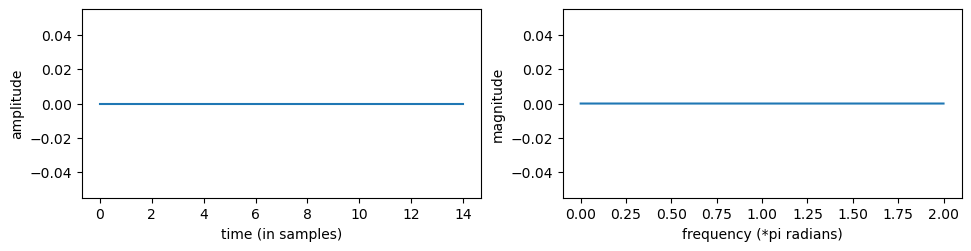

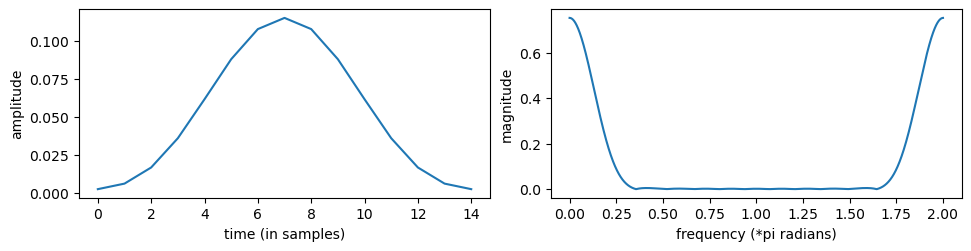

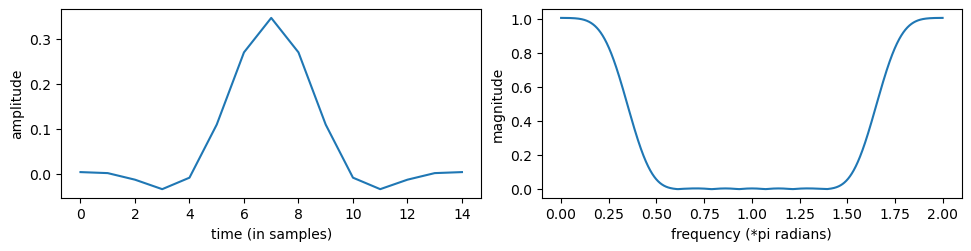

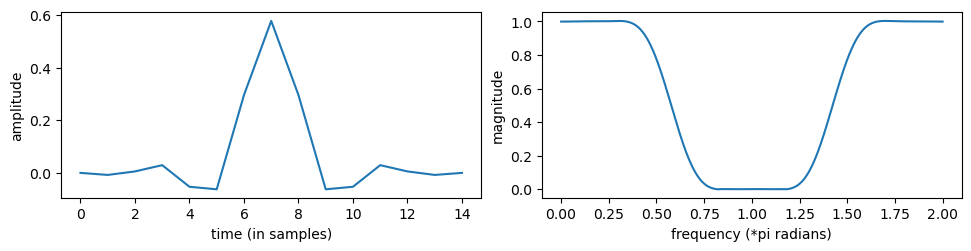

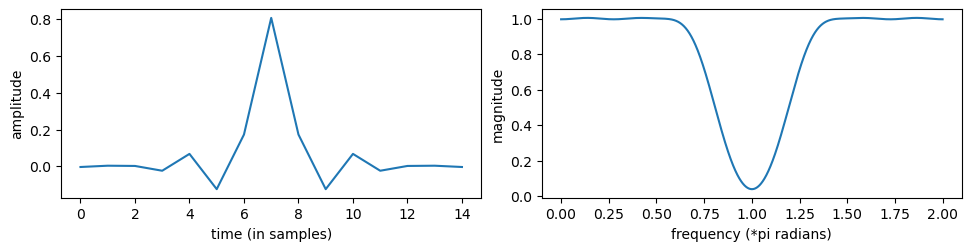

In [13]:
freq_list = [0, 50, 100, 150, 200]
for i in range(len(freq_list)):
    plt.figure(figsize=(FIG_SIZE)*np.array([1.2,0.8]), constrained_layout=True)
    drawFIRFFT(x2[freq_list[i]], NFFT=2048)


In [14]:
# returns decibel, with preventing 0 input
# note: input should be X(w) or x[n]
# dB = 20 log_10 (abs(x)) = 10 log_10 ( x^2 ) 
def decibel_sq_safe(x, epsilon=1e-10):
    return 10*np.log10(np.maximum(np.real(x*np.conj(x)),epsilon))

def drawspectrogram2(x, Nf, Ns=None, winname='hamming', minpercentile=80, isdbscale=True, isdraw=True):
    # Short-time Fourier transform with half-overlap 
    # Nf: analysis size
    # Ns: shift size 
    # NFFT: FFT size, power of 2
    if Ns==None: Ns=Nf//2
    num_frames = (len(x)-Nf)//Ns+1  # 마지막 채워지지 않은 프레임은 버린다. 구현에 따라 zero-padding해서 사용 가능
    NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
    hNo = NFFT//2+1
    X = np.zeros((hNo,num_frames))
    
    # generate window
    if winname=='rect' or winname=='rectangular':
        win = np.ones(Nf)
    else:   # hamming, hann, etc.
        win = librosa.filters.get_window(winname, Nf, fftbins=True)
        
    # STFT
    for i in range(num_frames):
        y = np.fft.fft(win*x[(i*Ns):(i*Ns+Nf)], n=NFFT)
        y = y[:hNo]
        if isdbscale: y = decibel_sq_safe(y)
        else: y = np.abs(y)
        X[:,i] = y

    if isdraw:
        # 상위 80% 정도만 scale 한다. imshow의 vmin vmax 이용 
        vmax = np.max(X[:])
        vmin = np.percentile(X[:], minpercentile)
        specgram_axis = [0,float(len(x))/float(Fs),0,float(Fs)/2]
        plt.imshow(X, cmap=cmap_plot, aspect='auto', origin='lower', extent=specgram_axis, vmax=vmax, vmin=vmin)
        plt.xlabel('time (seconds)')
        plt.ylabel('frequency (Hz)')
    
    return X

In [15]:
# parameters for signal analysis
# Fs = 16000  native sampling frequency (wav file 에 정의된 것) 을 사용하면 필요 없음
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

x, Fs = librosa.load('./gjang-kdigits0-3.wav', sr=None, mono='True')

print(x,x.shape)

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
print('Fs = %d, Ns = %d, Nf = %d, NFFT = %d' % (Fs, Ns, Nf, NFFT))

[-4.7912598e-03 -3.7231445e-03 -3.3569336e-03 ... -3.0517578e-05
 -8.8500977e-04  8.5449219e-04] (37952,)
Fs = 16000, Ns = 160, Nf = 320, NFFT = 512


array([[ -6.34682423,  -4.80354566,  -4.75009725, ...,  -9.22167749,
         -8.97639893,  -8.95841878],
       [ -9.3297527 ,  -7.29185556,  -7.57457147, ..., -11.46475608,
        -11.88629002, -11.28359794],
       [-18.72135734, -15.43623465, -17.50554461, ..., -17.56453303,
        -22.52575405, -18.84708645],
       ...,
       [-56.01415578, -52.65923911, -57.20669589, ..., -50.26604027,
        -58.1405211 , -59.7896021 ],
       [-55.38663495, -52.45361409, -59.32722557, ..., -53.33585703,
        -59.46355521, -63.58511903],
       [-55.0561334 , -52.97660532, -57.13328703, ..., -55.64997631,
        -67.95368392, -65.96255574]])

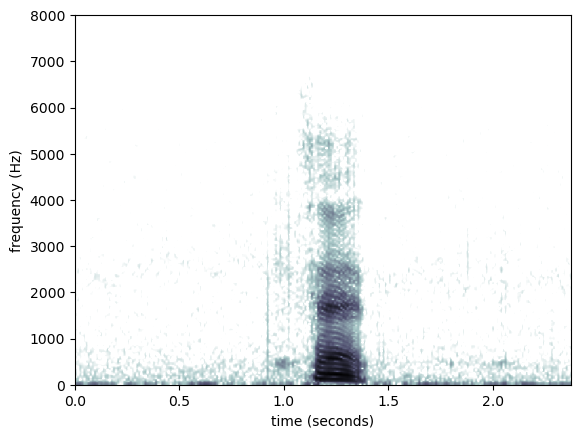

In [16]:
drawspectrogram2(x, Nf, Ns, 'hamming')

(48,) (48,)


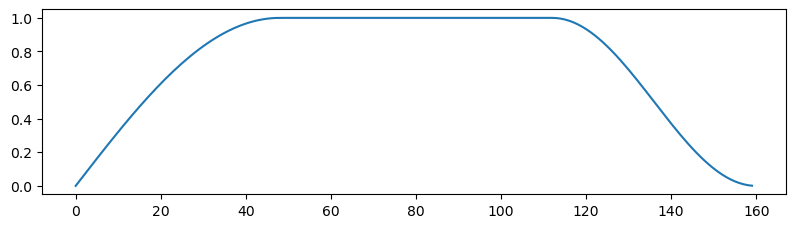

In [25]:
trap = trapezoidal_win(cutoff_freq=100, fs=16000, side_size=0.3, center_size=0.4)
plt.figure(figsize=FIG_SIZE*np.array([1.2,0.8]))
plt.plot(trap)